In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../gefera')
import gefera as gf

In [2]:
t1 = np.linspace(67.8, 68.8, 1000)
t2 = t1 + 365
t = np.hstack((t1, t2))

ap = 1.0
tp = 0.2
ep = 0.2
pp = 365
wp = 0.1 * np.pi / 180
ip = 90.0 * np.pi / 180

am = 0.007
tm = -1.3
em = 0.1
pm = 3
om = 0.1 * np.pi / 180
wm = 90 * np.pi / 180
im = 88.0 * np.pi / 180
mm = 0.01

u1 = 0.5
u2 = 0.3
rp = 0.2
rm = 0.1

In [3]:
po = gf.BarycenterOrbit(ap, tp, ep, pp, wp, ip)
mo = gf.MoonOrbit(am, tm, em, pm, om, wm, im, mm)
sys = gf.System(po, mo)
lc = sys.lightcurve(t, u1, u2, rp, rm)
y = lc + np.random.randn(len(lc)) * 0.01

(67.8, 68.8)

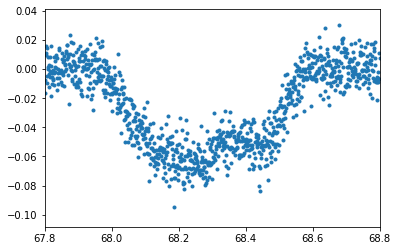

In [4]:
plt.plot(t, y, '.')
plt.xlim(67.8, 68.8)

In [5]:
import gefera_aesara as agf

In [ ]:
import pymc as pmc
from aesara import tensor as tt

with pmc.Model() as model:
        
    ab = pmc.Uniform(
        "ab", lower=0.8, upper=1.3, initval=1.0
    )
    tb = pmc.Uniform(
        "tb", lower=0.1, upper=0.3, initval=0.2
    )
    eb = pmc.Uniform(
        "eb", lower=0.0, upper=1.0, initval=0.2
    )
    pb = pmc.Uniform(
        "pb", lower=355, upper=375, initval=365
    )
    wb = pmc.Uniform(
        "wb", lower=-0.0001, upper=0.5, initval=0.1 * np.pi / 180
    )
    ib = pmc.Uniform(
        "ib", lower=88*np.pi/180, upper=90.1*np.pi/180, initval=np.pi/2
    )
    
    am = pmc.Uniform(
        "am", lower=0.0, upper=0.1, initval=0.007
    )
    tm = pmc.Uniform(
        "tm", lower=-2.0, upper=0.0, initval=-1.2
    )
    em = pmc.Uniform(
        "em", lower=0.0, upper=1.0, initval=0.1
    )
    pm = pmc.Uniform(
        "pm", lower=2.0, upper=4.0, initval=3.0
    )
    om = pmc.Uniform(
        "om", lower=0.0, upper=0.2, initval=0.1
    )
    wm = pmc.Uniform(
        "wm", lower=0.0, upper=np.pi, initval=np.pi/2
    )
    im = pmc.Uniform(
        "im", lower=0.0, upper=np.pi/2, initval=np.pi * 88 / 180
    )
    mm = pmc.Uniform(
        "mm", lower=0.0, upper=1.0, initval=0.01
    )
    
    q1 = pmc.Uniform("q1", lower=0.0, upper=1.0, initval=0.5)
    q2 = pmc.Uniform("q2", lower=0.0, upper=1.0, initval=0.2)
    u1 = 2 * tt.sqrt(q1) * q2
    u2 = tt.sqrt(q1) * (1 - 2 * q2)
    
    rp = pmc.Uniform("rp", lower=0.15, upper=0.5, initval=0.2)
    rm = pmc.Uniform("rm", lower=0.0, upper=0.15, initval=0.1)
    
    lsigma = pmc.Uniform(
        "lsigma", lower=np.log(0.001), upper=np.log(0.1), initval=np.log(0.01)
    )
    
    bo = agf.BarycenterOrbit(ab, tb, eb, pb, wb, ib)
    mo = agf.MoonOrbit(am, tm, em, pm, om, wm, im, mm)
    sys = agf.System(bo, mo)
    
    obs = pmc.Normal(
        "obs",
        mu=sys.lightcurve(t, u1, u2, rp, rm), 
        sigma=tt.exp(lsigma), 
        observed=y
    )
    
    trace = pmc.sample(
        2000, 
        tune=2000, 
        cores=2, 
        init='adapt_full'
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/usr/local/lib/python3.8/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


In [ ]:
import arviz as az
az.plot_pair(trace, divergences=True);

In [ ]:
n = 1000
df = trace.to_dataframe()
inds = np.random.randint(10000, size=n)

plt.figure(figsize=(10, 10))
for i in inds:
    ap = df['posterior', 'ab'][i]
    tp = df['posterior', 'tb'][i]
    pp = df['posterior', 'pb'][i]
    wp = df['posterior', 'wb'][i]
    ip = df['posterior', 'ib'][i]
    am = df['posterior', 'am'][i]
    tm = df['posterior', 'tm'][i]
    pm = df['posterior', 'pm'][i]
    om = df['posterior', 'om'][i]
    wm = df['posterior', 'wm'][i]
    im = df['posterior', 'im'][i]
    mm = df['posterior', 'mm'][i]
    ep = df['posterior', 'ep'][i]
    em = df['posterior', 'em'][i]
    q1 = df['posterior', 'q1'][i]
    q2 = df['posterior', 'q2'][i]
    rp = df['posterior', 'rp'][i]
    rm = df['posterior', 'rm'][i]
    plt.plot(t, model.obs.eval(
        {
            model.ap:ap, 
            model.tp:tp, 
            model.pp:pp, 
            model.wp:wp, 
            model.ip:ip,
            model.am:am,
            model.tm:tm,
            model.pm:pm,
            model.om:om,
            model.wm:wm,
            model.im:im,
            model.mm:mm,
            model.ep:ep,
            model.em:em,
            model.q1:q1,
            model.q2:q2,
            model.rp:rp,
            model.rm:rm,
            model.lsigma:-100
        }
    ), 'r-', alpha=0.1, linewidth=2)
    
plt.plot(t, y, 'bo', alpha=0.3)
plt.plot(t, lctrue, 'k-', linewidth=2)
plt.savefig('/Users/tgordon/Desktop/pymc.pdf')